<a href="https://www.kaggle.com/code/laxmikurapati/quora-question-similarity-with-bert?scriptVersionId=138401292" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import pandas

questions_dataset = pandas.read_csv("/kaggle/input/datacsvp/train.csv", index_col="id", nrows=3000)
questions_dataset.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Let's see what we got:

In [3]:
questions_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   qid1          3000 non-null   int64 
 1   qid2          3000 non-null   int64 
 2   question1     3000 non-null   object
 3   question2     3000 non-null   object
 4   is_duplicate  3000 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 140.6+ KB


In [4]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

Split a sentence into tokens:

In [5]:
print(f"Original: {questions_dataset['question1'][0]}")
print(f"Tokenized: {tokenizer.tokenize(questions_dataset['question1'][0])}")
print(f"Token IDs: {tokenizer.convert_tokens_to_ids(tokenizer.tokenize(questions_dataset['question1'][0]))}")

Original: What is the step by step guide to invest in share market in india?
Tokenized: ['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india', '?']
Token IDs: [2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1999, 2634, 1029]


We can combine ``tokenize`` and ``convert_tokens_to_ids`` with the method ``encode``:

In [6]:
print(f"Original: {questions_dataset['question2'][0]}")
print(f"Tokenized: {tokenizer.encode(questions_dataset['question2'][0])}")

Original: What is the step by step guide to invest in share market?
Tokenized: [101, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1029, 102]


We can see we got two extra tokens ``101`` and ``102``. Let's see what they are:

In [7]:
tokenizer.decode([101, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1029, 102])

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

'[CLS] what is the step by step guide to invest in share market? [SEP]'

## Special Tokens
``[SEP]`` - At the end of every sentence, we need to append the special ``[SEP]`` token.

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (remeber BERT was trained intially to perdict question-answering task).

``[CLS]`` - For classification tasks, we must prepend the special ``[CLS]`` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output.

So now let's see how to encode the two questions together:

In [8]:
encoded_pair = tokenizer.encode(questions_dataset['question1'][0], questions_dataset['question2'][0])
tokenizer.decode(encoded_pair)

'[CLS] what is the step by step guide to invest in share market in india? [SEP] what is the step by step guide to invest in share market? [SEP]'

## Sentence Length

The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:

1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.
Padding is done with a special ``[PAD]`` token, which is at index 0 in the BERT vocabulary.

The maximum length does impact training and evaluation speed.

Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to.

Let's find the maximum length of question pairs:

In [9]:
from tqdm import tqdm



tqdm.pandas()
questions_dataset["question1_length"] = questions_dataset["question1"].progress_apply(lambda question: 
                                                                                      len(tokenizer.tokenize(question)))
questions_dataset["question2_length"] = questions_dataset["question2"].progress_apply(lambda question: 
                                                                                      len(tokenizer.tokenize(question)))
questions_dataset["joint_length"] = questions_dataset["question1_length"] + questions_dataset["question2_length"]
questions_dataset["joint_length"].max()

100%|██████████| 3000/3000 [00:00<00:00, 8525.90it/s]


141

We will choose max length of 310.

# Training & Validation Split

I'm going to spit the set into 3200 records for train (64%), 800 records for validation (16%) and 1000 records for test (20%).

Let's Create train, validation and test:

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(questions_dataset[["question1", "question2"]], 
                                                    questions_dataset["is_duplicate"], test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train.head()

,question1,question2
id,,
1221,Which is a suitable solar panel installation p...,Which is a good solar panel installation provi...
1651,Why don't we connect the direct DC power that ...,Since India has its own one nation one grid co...
1460,A couple who has 5 sons went for a picnic. Eac...,"Why are there so many ""no picnic"" signs in Ven..."
1081,Did Trump win the election?,What do you think of Trump winning the elections?
1405,"What does the Tagalog word ""salamat"" mean in E...",Tagalog: What does salamat po mean in English?


In [11]:
y_train.head()

id
1221    0
1651    0
1460    0
1081    0
1405    0
Name: is_duplicate, dtype: int64

# Tokenize Dataset and Create Dataloader

Now we’re ready to perform the real tokenization.

The tokenizer.encode_plus function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special ``[CLS]`` and ``[SEP]`` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from ``[PAD]`` tokens.

Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).

In [12]:
max_length = 300
tokenizer.encode_plus(X_train.iloc[0]["question1"], X_train.iloc[0]["question2"], max_length=max_length, 
                      pad_to_max_length=True, return_attention_mask=True, return_tensors='pt', truncation=True)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': tensor([[  101,  2029,  2003,  1037,  7218,  5943,  5997,  8272, 10802,  2379,
          2148,  4796,  1010,  2662,  6187,  1029,   102,  2029,  2003,  1037,
          2204,  5943,  5997,  8272, 10802,  2379,  2358,  7076,  2239,  3509,
          1010,  2662,  6187,  1029,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

So what we got:

1. input_ids - Token ids padded with 0 at the end.
2. token_type_ids - This array indicates bert what is the first sentence and what is the seconds. In case of classification of only one sentance this array is redundant.
3. attention_mask - The “Attention Mask” is simply an array of 1s and 0s indicating which tokens are padding and which aren’t. This mask tells the “Self-Attention” mechanism in BERT not to incorporate these ``[PAD]`` tokens into its interpretation of the sentence.

All the array are in the size of ``max_length``.

Now let's create our datasets:

In [13]:
import torch

from tqdm import tqdm
from torch.utils.data import TensorDataset
def convert_to_dataset_torch(data: pandas.DataFrame, labels: pandas.Series) -> TensorDataset:
    input_ids = []
    attention_masks = []
    token_type_ids = []
    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        encoded_dict = tokenizer.encode_plus(row["question1"], row["question2"], max_length=max_length, pad_to_max_length=True, 
                      return_attention_mask=True, return_tensors='pt', truncation=True)
        # Add the encoded sentences to the list.
        input_ids.append(encoded_dict['input_ids'])
        token_type_ids.append(encoded_dict["token_type_ids"])
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    token_type_ids = torch.cat(token_type_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.values)
    
    return TensorDataset(input_ids, attention_masks, token_type_ids, labels)

In [14]:

train = convert_to_dataset_torch(X_train, y_train)
validation = convert_to_dataset_torch(X_validation, y_validation)


100%|██████████| 480/480 [00:00<00:00, 1219.75it/s]


We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory:

In [15]:
import multiprocessing

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.

batch_size = 20

core_number = multiprocessing.cpu_count()

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train,  # The training samples.
            sampler = RandomSampler(train), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
            num_workers = core_number
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            validation, # The validation samples.
            sampler = SequentialSampler(validation), # Pull out batches sequentially.
            batch_size = batch_size, # Evaluate with this batch size.
            num_workers = core_number
        )

# Trainig the Classification Model
Now that our input data is properly formatted, it’s time to fine tune the BERT model.
## BertForSequenceClassification
For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

We’ll be using [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

OK, let’s load BERT! There are a few different pre-trained BERT models available. “bert-base-uncased” means the version that has only lowercase letters (“uncased”) and is the smaller version of the two (“base” vs “large”).

In [16]:
from transformers import BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 

bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels=2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions=False, # Whether the model returns attentions weights.
    output_hidden_states=False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

# Optimizer & Learning Rate Scheduler
Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

I chose:
* Batch size: 32
* Learning rate: 2e-5
* Number of epochs: 2

All due to hardware performance issues.

Let's create our optimizer:

In [17]:
from transformers import AdamW
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
adamw_optimizer = AdamW(bert_model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


The epsilon parameter eps = 1e-8 is “a very small number to prevent any division by zero in the implementation”.

Let's create the learning rate scheduler:

In [18]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 1

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(adamw_optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

# Training Loop
Helper function for formatting elapsed times as ``hh:mm:ss``:

In [19]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

This method is to train one batch over our model:

In [20]:
def fit_batch(dataloader, model, optimizer, epoch):
    total_train_loss = 0
    
    for batch in tqdm(dataloader, desc=f"Training epoch:{epoch}", unit="batch"):
        # Unpack batch from dataloader.
        input_ids, attention_masks, token_type_ids, labels = batch
        
        # clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        
        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        
    return total_train_loss

This method is evalute one batch over our model. We're going to use scikit learn [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html):

In [21]:
import numpy

from sklearn.metrics import accuracy_score

def eval_batch(dataloader, model, metric=accuracy_score):
    total_eval_accuracy = 0
    total_eval_loss = 0
    predictions , predicted_labels = [], []
    
    for batch in tqdm(dataloader, desc="Evaluating", unit="batch"):
        # Unpack batch from dataloader.
        input_ids, attention_masks, token_type_ids, labels = batch
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
        total_eval_loss += loss.item()
        
        # Calculate the accuracy for this batch of validation sentences, and
        # accumulate it over all batches.
        y_pred = numpy.argmax(logits.detach().numpy(), axis=1).flatten()
        total_eval_accuracy += metric(labels, y_pred)
        
        predictions.extend(logits.detach().numpy().tolist())
        predicted_labels.extend(y_pred.tolist())
    
    return total_eval_accuracy, total_eval_loss, predictions ,predicted_labels

Main loop method:

In [22]:
import random

# Set the seed value all over the place to make this reproducible.

seed_val = 10

random.seed(seed_val)
numpy.random.seed(seed_val)
torch.manual_seed(seed_val)


def train(train_dataloader, validation_dataloader, model, optimizer, epochs):
    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []
    
    # Measure the total training time for the whole run.
    total_t0 = time.time()
    
    for epoch in range(0, epochs):
        
        # Measure how long the training epoch takes.
        t0 = time.time()
        
        # Reset the total loss for this epoch.
        total_train_loss = 0
        
        # Put the model into training mode. 
        model.train()
        
        total_train_loss = fit_batch(train_dataloader, model, optimizer, epoch)
        
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
        
        t0 = time.time()
        
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()
        
        total_eval_accuracy, total_eval_loss, _, _ = eval_batch(validation_dataloader, model)
        
        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        
        print(f"  Accuracy: {avg_val_accuracy}")
    
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
    
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
    
        print(f"  Validation Loss: {avg_val_loss}")
    
        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
        

    print("")
    print("Training complete!")

    print(f"Total training took {format_time(time.time()-total_t0)}")
    return training_stats

We’re ready to kick off the training:

In [23]:
training_stats = train(train_dataloader, validation_dataloader, bert_model, adamw_optimizer, epochs)

Training epoch:0:   0%|          | 0/96 [00:00<?, ?batch/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training epoch:0: 100%|██████████| 96/96 [48:33<00:00, 30.09s/batch] 

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating:   0%|          | 0/24 [00:00<?, ?batch/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating: 100%|██████████| 24/24 [03:50<00:00,  9.62s/batch]

  Accuracy: 0.74375
  Validation Loss: 0.5148955409725507

Training complete!
Total training took 0:52:25


Let’s view the summary of the training process:

In [24]:
df_stats = pandas.DataFrame(training_stats).set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
0,0.59672,0.514896,0.74375,0:48:34,0:03:51


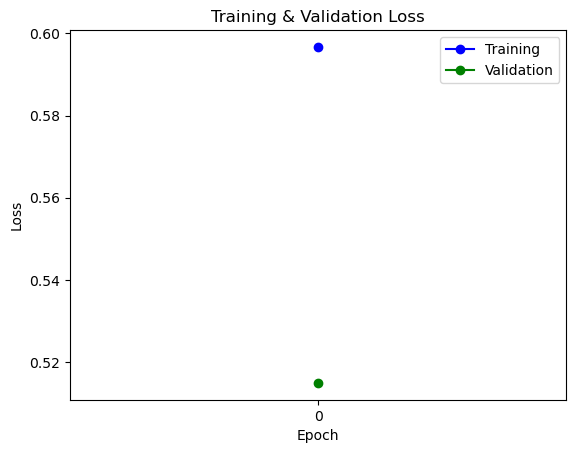

In [25]:
from matplotlib import pyplot
%matplotlib inline
pyplot.plot(df_stats['Training Loss'], 'b-o', label="Training")
pyplot.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
pyplot.title("Training & Validation Loss")
pyplot.xlabel("Epoch")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.xticks(df_stats.index.values.tolist())
pyplot.show()

# Performance On Test Set
## Data Preparation

In [26]:
test = convert_to_dataset_torch(X_test, y_test)
test_dataloader = DataLoader(test,  sampler=SequentialSampler(test), batch_size=batch_size)

  0%|          | 0/600 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 600/600 [00:00<00:00, 1215.98it/s]


## Evaluate on Test Set
With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set:

In [27]:
bert_model.eval()

_, _,_ ,predicted_labels = eval_batch(test_dataloader, bert_model)

Evaluating: 100%|██████████| 30/30 [04:53<00:00,  9.79s/batch]


Let's plot confusion matix over the test results:

In [28]:
!pip install ds_utils

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.6 MB/s eta 0:00:0000:0100:01
  Created wheel for ds_utils: filename=ds_utils-0.4.1-py3-none-any.whl size=2659 sha256=0f01ffc598575b4ddc8c3f8814e0fe4b6b277a056c6e47f6a5490065cfe8e366
  Stored in directory: /root/.cache/pip/wheels/49/58/05/627bdfaf592214bc7588a119920d4499598d147b4e1f691513
Successfully built ds_utils


In [29]:
# !pip install ds_utils
from ds_utils.metrics import plot_confusion_matrix


plot_confusion_matrix(y_test, predicted_labels, [1, 0])
pyplot.show()

ModuleNotFoundError: No module named 'ds_utils'

# Saving the Fine-Tuned Model
First let's save our model with the method ``save_pretrained``, then save our tokenizer with ``save_pretrained``.

**Pay Attension**: tokenizer's ``save_pretrained`` need to get the path to save as a string.

In [ ]:
from pathlib import Path



output_dir = Path("__file__").parents[0].absolute().joinpath("model_save")
output_dir.mkdir(exist_ok=True)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = bert_model.module if hasattr(bert_model, 'module') else bert_model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(str(output_dir.absolute()))